In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

from datetime import timedelta as td
import calendar
import warnings


In [3]:
# toy_df = pd.read_csv("forecast/toy_sales.csv")
# toy_wide_df = (
#     toy_df
#     .drop(columns=['Sale_ID', 'Store_ID'])
#     .groupby(['Date', 'Product_ID'])
#     .sum('Units').reset_index()
#     .rename(columns={'Date':'datetime'})
#     .assign(Product_ID = lambda d : d.Product_ID.astype(str), datetime = lambda d:pd.to_datetime(d.datetime))
#     .pivot(index='datetime', columns='Product_ID', values='Units')
#     .join(pd.DataFrame(index=pd.date_range('2017-01-01', '2018-09-30')), how='right')
#     .reset_index()
#     .rename(columns={'index':'datetime'})
#     )
# toy_wide_df

In [5]:
def load_raw_dataframe():
    cols = ['date',	'time', 'ticket_number', 'article', 'Quantity', 'unit_price']
    raw_df = (
        pd
        .read_csv("../Bakery sales.csv", usecols=cols)
        .assign(
            datetime = lambda d : pd.to_datetime(d.date), #+ "T" + d.time),
            quantity = lambda d : d.Quantity.astype(int),
            ticket_number = lambda d : d.ticket_number.astype(int)
        )
        .drop(columns=['date', 'time', 'Quantity'])
        )
    return raw_df

raw_df = load_raw_dataframe()
raw_df.head()

,ticket_number,article,unit_price,datetime,quantity
0,150040,BAGUETTE,"0,90 €",2021-01-02,1
1,150040,PAIN AU CHOCOLAT,"1,20 €",2021-01-02,3
2,150041,PAIN AU CHOCOLAT,"1,20 €",2021-01-02,2
3,150041,PAIN,"1,15 €",2021-01-02,1
4,150042,TRADITIONAL BAGUETTE,"1,20 €",2021-01-02,5


In [60]:
def create_long_n_wide_dataframes(raw_df):

    wide_df = (
        raw_df
        .groupby(['article', 'datetime'])
        .sum('quantity').reset_index()
        .pivot(index='datetime', columns='article', values='quantity')
        .pipe(lambda d : d[[col for col in d.columns if col != "."]])
        .join(pd.DataFrame(index=pd.date_range('2021-01-01', '2022-09-30')), how='right')
        .ffill()
        .fillna(0)
        .reset_index()
        .rename(columns={'index':'datetime'})
    )

    long_df = wide_df.melt(id_vars='datetime', var_name='article', value_name='quantity')
    return long_df, wide_df

long_df, wide_df = create_long_n_wide_dataframes(raw_df)
print("WIDE DATAFRAME")
display(wide_df.head())
print("LONG DATAFRAME")
display(long_df.head())

WIDE DATAFRAME


,datetime,12 MACARON,ARMORICAIN,ARTICLE 295,BAGUETTE,BAGUETTE APERO,BAGUETTE GRAINE,BANETTE,BANETTINE,BOISSON 33CL,...,THE,TRADITIONAL BAGUETTE,TRAITEUR,TRIANGLES,TROIS CHOCOLAT,TROPEZIENNE,TROPEZIENNE FRAMBOISE,TULIPE,VIENNOISE,VIK BREAD
0,2021-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2021-01-02,0.0,0.0,0.0,46.0,0.0,0.0,40.0,6.0,0.0,...,0.0,128.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0
2,2021-01-03,0.0,0.0,0.0,35.0,0.0,8.0,35.0,5.0,0.0,...,0.0,171.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
3,2021-01-04,0.0,0.0,0.0,30.0,0.0,8.0,24.0,3.0,1.0,...,0.0,128.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0
4,2021-01-05,0.0,0.0,0.0,29.0,0.0,8.0,26.0,2.0,3.0,...,0.0,99.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0


LONG DATAFRAME


,datetime,article,quantity
0,2021-01-01,12 MACARON,0.0
1,2021-01-02,12 MACARON,0.0
2,2021-01-03,12 MACARON,0.0
3,2021-01-04,12 MACARON,0.0
4,2021-01-05,12 MACARON,0.0


/home/bashir/miniconda3/envs/ipython_experimental/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bashir/miniconda3/envs/ipython_experimental/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bashir/miniconda3/envs/ipython_experimental/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/bashir/miniconda3/envs/ipython_experimental/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWar

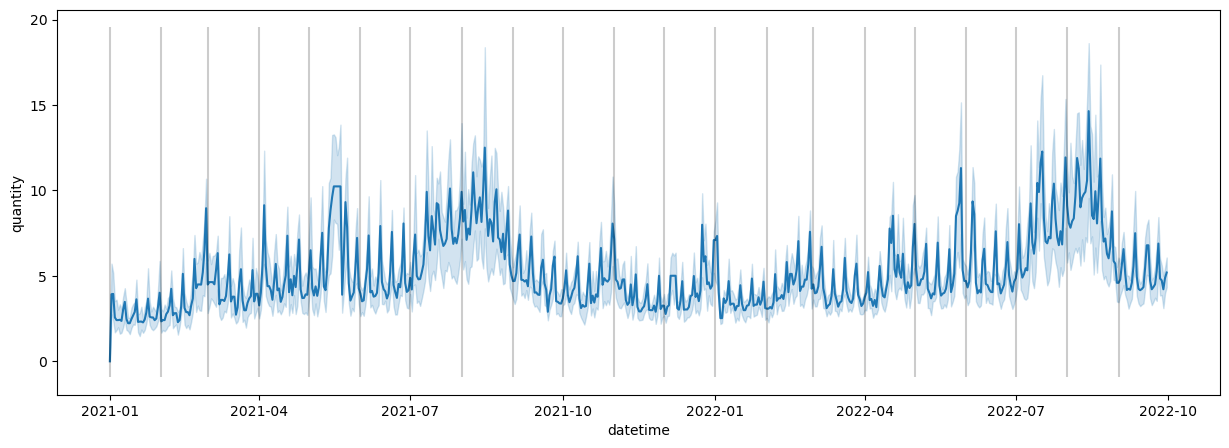

In [61]:
def plot_mean_sales(long_df, wide_df):
    plt.figure(figsize=[15,5])
    sns.lineplot(
        data=long_df, 
        x = 'datetime',
        y = 'quantity',
        errorbar=('ci', 67),
        estimator='mean',
        n_boot=30
        # y = [col for col in article_sales_df.columns if col not in ['.', 'datetime']]
    )
    plt.vlines(wide_df.datetime[wide_df.datetime.dt.day==1], ymin=plt.ylim()[0], ymax=plt.ylim()[1], color="black", alpha=0.2)
plot_mean_sales(long_df, wide_df)

In [62]:
def append_date_feats(df, min_datetime=None):
    if min_datetime == None:
        min_datetime = df.datetime.min()
    step = (df.datetime-min_datetime).dt.days
    day_of_month = pd.get_dummies(df.datetime.dt.day)
    day_of_week = pd.get_dummies(df.datetime.dt.weekday)
    return df.assign(
        step=step / 365,
        **{f"month_{int(ic)}" : day_of_month[int(ic)] for ic in day_of_month.columns},
        **{f"week_{int(ic)}" : day_of_week[int(ic)] for ic in day_of_week.columns}
    )

def append_lag_feats(df, target_col, lags = [1]):
    return df.assign(**{ f"lag_{lag}":df[target_col].shift(lag) for lag in lags})

def append_rolling_mean_feat(df, target_col, rolling_mean_windows=[7]):
    return df.assign(**{f"rolling_window_{rolling_mean_window}" : df[target_col].rolling(rolling_mean_window).mean().shift(1) for rolling_mean_window in rolling_mean_windows})

In [63]:
def process_article(article_df):
    return (
        article_df
        .pipe(append_lag_feats, target_col='target', lags=[1,2,3,4,5,6,7,14,21,28])
        .pipe(append_rolling_mean_feat, target_col='target')
        .pipe(append_date_feats)
    )

def build_n_train_model(df, ModelClass = LinearRegression, verbose=False):
    X = df.drop(columns=['target', 'datetime']).fillna(0)
    y = df['target']
    Xtrain, Xtest = X[:-100], X[-100:]
    ytrain, ytest = y[:-100], y[-100:]

    model = ModelClass()
    model.fit(Xtrain, ytrain)

    results = pd.DataFrame({
        'train' : [ mean_absolute_error(x, ytrain) for x in [Xtrain['lag_1'], Xtrain['lag_7'], Xtrain['rolling_window_7'], model.predict(Xtrain)]],
        'test' : [ mean_absolute_error(x, ytest) for x in [Xtest['lag_1'], Xtest['lag_7'], Xtest['rolling_window_7'], model.predict(Xtest)]]
    }, index=['lag1', 'lag7', 'rolling_window_7', model.__class__.__name__])
    results = results.reset_index().rename(columns={'index' : 'model'}).melt(id_vars='model', var_name='dataset', value_name='MAE')

    results_mape = pd.DataFrame({
        'train' : [ mean_absolute_percentage_error(x+1, ytrain+1) for x in [Xtrain['lag_1'], Xtrain['lag_7'], Xtrain['rolling_window_7'], model.predict(Xtrain)]],
        'test' : [ mean_absolute_percentage_error(x+1, ytest+1) for x in [Xtest['lag_1'], Xtest['lag_7'], Xtest['rolling_window_7'], model.predict(Xtest)]]
    }, index=['lag1', 'lag7', 'rolling_window_7', model.__class__.__name__])
    # print(results_mape)
    results_mape = results_mape.reset_index().rename(columns={'index' : 'model'}).melt(id_vars='model', var_name='dataset', value_name='MAPE')
    results = results.assign(MAPE = results_mape.MAPE)

    if verbose:
        print(">>> TRAIN <<<")
        print(f"""
        LAG1\t{results.loc['lag1', 'train']},
        LAG2\t{results.loc['lag7', 'train']},
        RW  \t{results.loc['rolling_window7', 'train']},
        MODEL  \t{results.loc['model', 'train']},
        """)

        print(">>> TEST <<<")
        print(f"""
        LAG1\t{results.loc['lag1', 'test']},
        LAG2\t{results.loc['lag7', 'test']},
        RW  \t{results.loc['rolling_window7', 'test']},
        MODEL  \t{results.loc['model', 'test']},
        """)

    return model, results

In [64]:
def auto_regress(model, df, target_col='target', horizon=14):
    last_datetime = df.datetime.max()
    for i in range(1, horizon+1):
        last_datetime = last_datetime + td(days=1)

        # append new dummy row for new date to get features
        new_row = pd.DataFrame({'datetime': [last_datetime], target_col : [0]})
        df = pd.concat([df, new_row]).reset_index(drop=True).pipe(process_article) #.pipe(append_lag_feats, target_col=target_col, lags=[1,7,14]).pipe(append_rolling_mean_feat, target_col=target_col, rolling_mean_windows=[7]).pipe(append_date_feats)
        last_row = df.query(f'datetime=="{last_datetime}"').drop(columns = ['datetime', target_col])
        pred = float(model.predict(last_row))

        # pull the index of new row out, replace dummy value with prediction in place
        idx = df.query(f'datetime=="{last_datetime}"').index[0]
        df.loc[idx, target_col] = pred
        df = df[['datetime', target_col]]
        
    return df

def plot_ar_results(target_df, ar_df):
    with plt.style.context('ggplot'):
        plt.figure(figsize=[15,5])
        sns.lineplot(
            data = (pd
                    .merge(target_df, ar_df.rename(columns={'target' : 'target_AR'}), on='datetime', how='outer')
                    .melt(id_vars='datetime', var_name='item', value_name='quantity')
                    ),
            x='datetime',
            y='quantity',
            hue='item',
            alpha=0.5,
            marker="*"
        )

In [87]:
df_outs = []

for month in range(1,13):
    first_of_month = pd.Timestamp(f"2022-{month}-01")
    df_in = df.query("datetime < @first_of_month")
    df_out = auto_regress(model1, df_in, horizon=calendar.monthrange(2022, month)[1]).query('datetime>=@first_of_month').rename(columns={'target' : 'target_AR'})
    df_outs.append(df_out)

/home/bashir/miniconda3/envs/ipython_experimental/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bashir/miniconda3/envs/ipython_experimental/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bashir/miniconda3/envs/ipython_experimental/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bashir/miniconda3/envs/ipython_experimental/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_c

<Axes: xlabel='datetime', ylabel='quantity'>

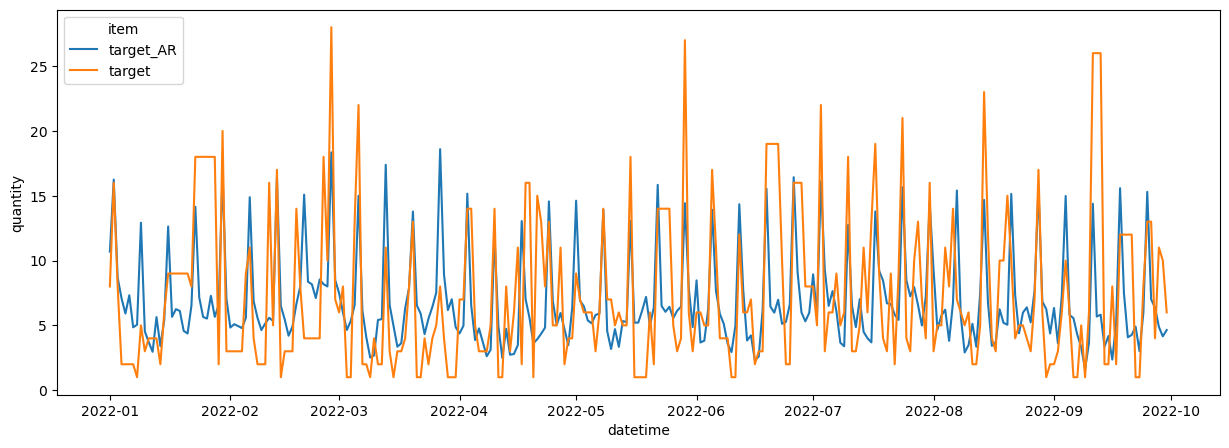

In [88]:
plt.figure(figsize=[15,5])
sns.lineplot(
    pd.concat(df_outs).merge(df, on='datetime').melt(id_vars='datetime', var_name='item', value_name='quantity'),
    x='datetime',
    y='quantity',
    hue='item'
)

,model,dataset,MAE,MAPE
0,lag1,train,4.637546,0.684230
1,lag7,train,5.765799,0.999163
2,rolling_window_7,train,5.111790,0.591889
3,LinearRegression,train,3.696160,0.543415
4,lag1,test,5.210000,0.737031
5,lag7,test,5.030000,0.840593
6,rolling_window_7,test,4.847143,0.548974
7,LinearRegression,test,3.982231,0.517842


,model,dataset,MAE,MAPE
0,lag1,train,4.637546,0.684230
1,lag7,train,5.765799,0.999163
2,rolling_window_7,train,5.111790,0.591889
3,MLPRegressor,train,0.957382,0.162304
4,lag1,test,5.210000,0.737031
5,lag7,test,5.030000,0.840593
6,rolling_window_7,test,4.847143,0.548974
7,MLPRegressor,test,4.283146,0.850305


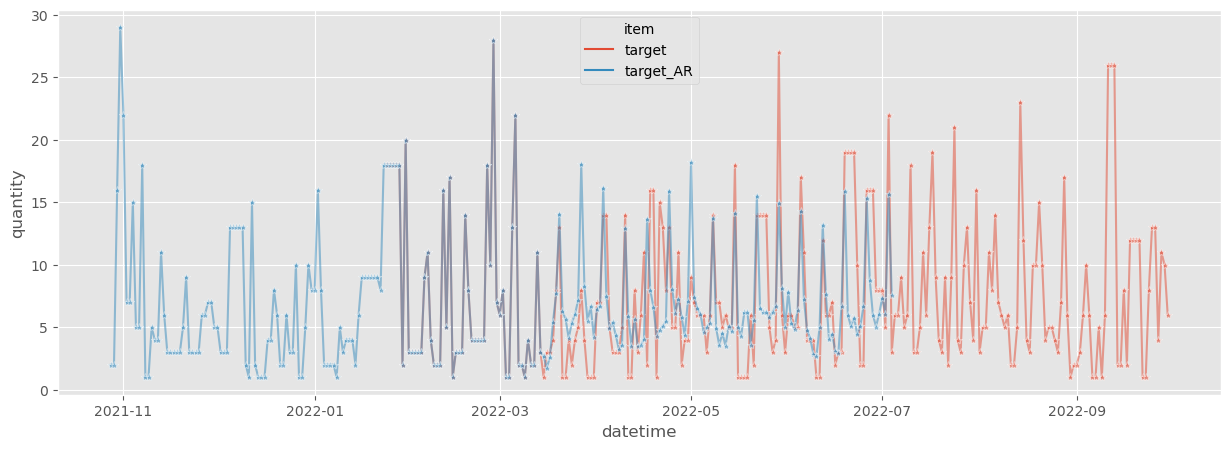

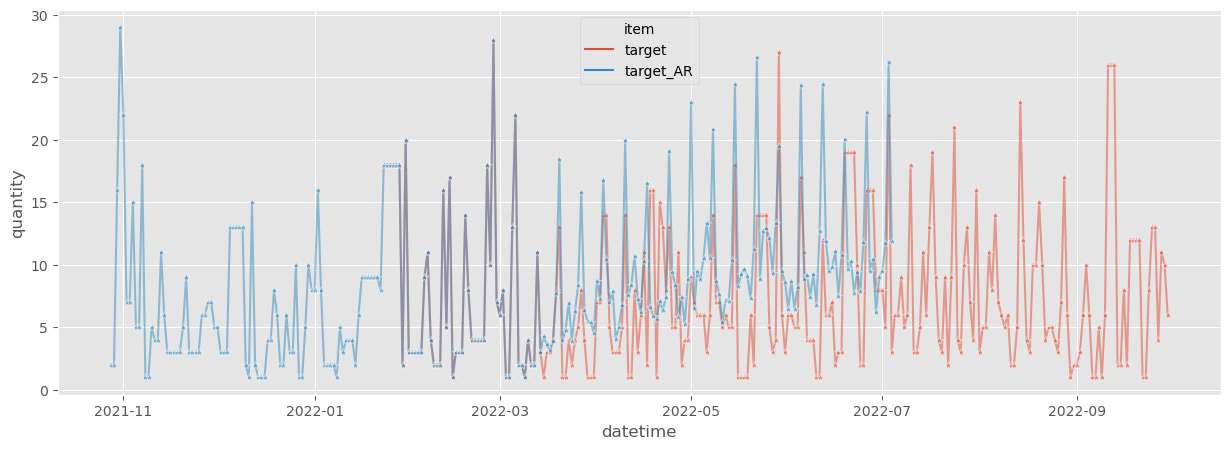

In [86]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    cutoff_point = 200
    df = wide_df[['datetime', 'ECLAIR']].rename(columns={'ECLAIR' : 'target'})
    model1, results1 = df.pipe(process_article).pipe(build_n_train_model, ModelClass=LinearRegression)
    # model2, results2 = df.pipe(process_article).pipe(build_n_train_model, ModelClass=lambda : RandomForestRegressor(max_depth=10, n_estimators=200))
    model2, results2 = df.pipe(process_article).pipe(build_n_train_model, ModelClass=lambda : MLPRegressor( hidden_layer_sizes= [250]*2, activation='relu', alpha=10))
    display(results1), display(results2)
    df_ar1 = auto_regress(model1, df.iloc[:-cutoff_point], horizon=112)
    df_ar2 = auto_regress(model2, df.iloc[:-cutoff_point], horizon=112)
    plot_ar_results(df.iloc[-(cutoff_point+50):], df_ar1.iloc[-(cutoff_point+50):])
    plot_ar_results(df.iloc[-(cutoff_point+50):], df_ar2.iloc[-(cutoff_point+50):])

In [66]:
articles = list(long_df.groupby('article').sum('quantity').sort_values(by='quantity', ascending=False).iloc[:500].index)

In [67]:
df_results = pd.DataFrame(columns=['article', 'model', 'dataset', 'MAE'])
for a in articles:
    model, results = wide_df[['datetime', a]].rename(columns={a:'target'}).pipe(process_article).pipe(build_n_train_model, ModelClass=LinearRegression)
    df_results = pd.concat([df_results, results.assign(article=a)])
df_results.sort_values(by=['article', 'dataset', 'model']) #.to_csv("LinearRegression.csv")

/tmp/ipykernel_13662/183581268.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, results.assign(article=a)])


,article,model,dataset,MAE,MAPE
7,12 MACARON,LinearRegression,test,1.170000,1.170000
4,12 MACARON,lag1,test,0.350000,0.126667
5,12 MACARON,lag7,test,0.530000,0.260833
6,12 MACARON,rolling_window_7,test,0.428571,0.181211
3,12 MACARON,LinearRegression,train,0.000000,0.000000
...,...,...,...,...,...
6,VIK BREAD,rolling_window_7,test,2.078571,0.196842
3,VIK BREAD,LinearRegression,train,2.544497,0.270578
0,VIK BREAD,lag1,train,2.226766,0.326452
1,VIK BREAD,lag7,train,4.477695,0.814466


In [82]:
df_results.article.unique()

array(['TRADITIONAL BAGUETTE', 'CROISSANT', 'PAIN AU CHOCOLAT', 'COUPE',
       'BANETTE', 'BAGUETTE', 'NID DE POULE', 'CEREAL BAGUETTE',
       'VIK BREAD', 'FORMULE SANDWICH', 'BAGUETTE GRAINE',
       'SPECIAL BREAD', 'TARTELETTE', 'BOULE 400G', 'ECLAIR', 'CAMPAGNE',
       'COOKIE', 'BOTTEREAU', 'BRIOCHETTE', 'COMPLET', 'FICELLE',
       'MOISSON', 'SANDWICH COMPLET', 'BOULE 200G', 'BANETTINE',
       'PAIN BANETTE', 'FRAISIER', 'KOUIGN AMANN', 'PAIN AUX RAISINS',
       'PAIN', 'CROISSANT AMANDES', 'QUIM BREAD', 'VIENNOISE',
       'CAFE OU EAU', 'PAIN CHOCO AMANDES', 'CHAUSSON AUX POMMES',
       'BOISSON 33CL', 'SAND JB EMMENTAL', 'GAL POMME 6P', 'SAVARIN',
       'MILLES FEUILLES', 'ROYAL', 'PARIS BREST', 'BRIOCHE', 'SUCETTE',
       'GRAND FAR BRETON', 'DIVERS PATISSERIE', 'TARTELETTE FRAISE',
       'TRAITEUR', 'CHOU CHANTILLY', 'FLAN', 'FINANCIER X5',
       'GD KOUIGN AMANN', 'PLATPREPARE6,50', 'SEIGLE', 'NOIX JAPONAISE',
       'FLAN ABRICOT', 'TROPEZIENNE', 'DEMI BAGUETTE

/home/bashir/miniconda3/envs/ipython_experimental/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bashir/miniconda3/envs/ipython_experimental/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bashir/miniconda3/envs/ipython_experimental/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/bashir/miniconda3/envs/ipython_experimental/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_c

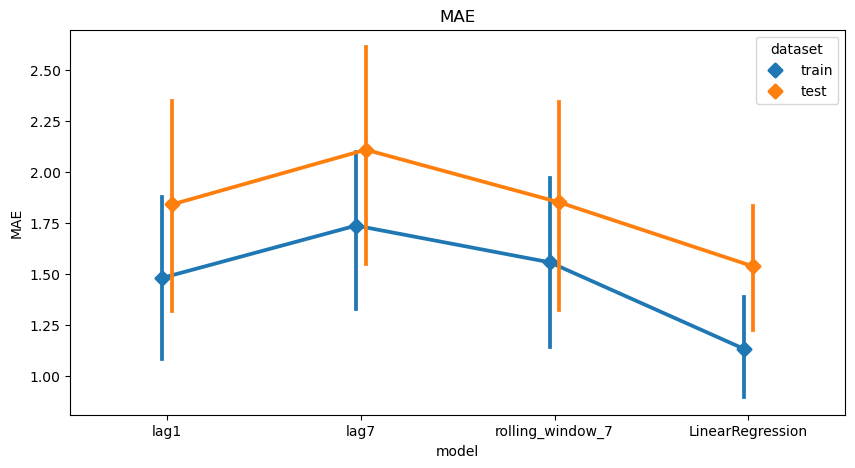

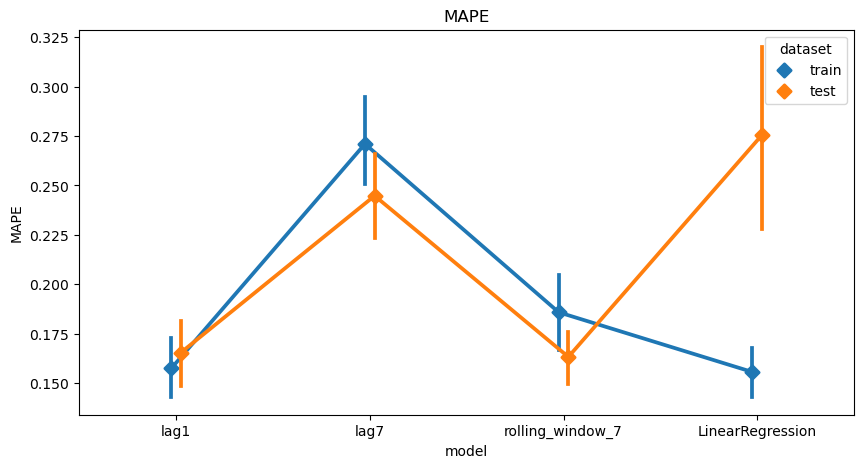

In [68]:
for metric in ["MAE", "MAPE"]:
    plt.figure(figsize=[10,5])
    plt.title(metric)
    sns.pointplot(
        data=df_results,
        x='model',
        y=metric,
        # hue='article',
        estimator='mean',
        hue='dataset',
        errorbar=('ci', 68),
        # err_style='bars',
        markers="D",
        dodge=True
    )